# **DSE group project**

Наша группа по проекту состоит из двух человек: Голованова Анна (4 гр.) и Атрошенко Юлия (4 гр.)

Мы решили взять авокаdata 🥑

Ну что-ж.... Начнем :))

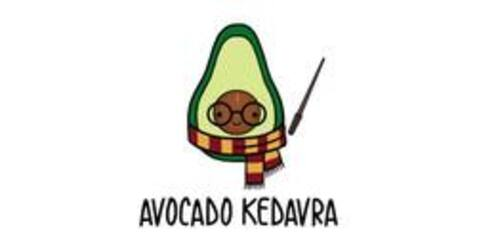

### **1. Take any time series of monthly or quarterly periodicity with seasonal pattern.**


Мы использовали набор данных, который содержит исторические данные о ценах на авокадо и объеме продаж в нескольких городах, штатах и регионах США с 2015 по 2020 год: https://www.kaggle.com/datasets/timmate/avocado-prices-2020/data

Для удобства работы с данными мы создали новый датасет с двумя столбиками: датами и соответствующими данных по выручке (или 'revenue').
Также мы совместили недельные показатели в месячные, взяв средние значения



In [ ]:
# # if open through jupyter notebook:
# import pandas as pd

# df = pd.read_csv("avocado-updated-2020.csv", sep=',')
# df.head()

In [ ]:
# if open through google colab: (1) choose needed csv file
from google.colab import files
uploaded = files.upload()

Saving avocado-updated-2020.csv to avocado-updated-2020.csv


In [ ]:
# if open through google colab: (2) run this cell
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['avocado-updated-2020.csv']))
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [ ]:
# Adding a new column 'revenue' ($, thousands) as the multiplication of 'average_price' and 'total_volume' from the original dataset
df['revenue'] = df['average_price'] * df['total_volume']/1000

# Drop all unnecessary columns
columns_to_drop = ['average_price',	'total_volume',	'4046',	'4225',	'4770',	'total_bags',	'small_bags',	'large_bags',	'xlarge_bags',	'type',	'year',	'geography']
df.drop(columns_to_drop, axis = 1, inplace = True)

# changing type of column 'date' to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# summing revenue for each order date
df.groupby('date')['revenue'].sum()

# grouping weekly revenue to obtain average monthly revenue
df = df['revenue'].resample('MS').mean()

# back to dataframe for convinience
df = df.to_frame()
df.reset_index(inplace=True)
df.columns = ['date', 'revenue']

# printing the final dataframe
df.head()

,date,revenue
0,2015-01-01,749.003069
1,2015-02-01,818.092397
2,2015-03-01,796.867171
3,2015-04-01,843.469160
4,2015-05-01,921.858878


In [ ]:
# check if there are any missing values
df.isna().sum()
df.isnull().sum()

date       0
revenue    0
dtype: int64

Finding and preparing data be like:

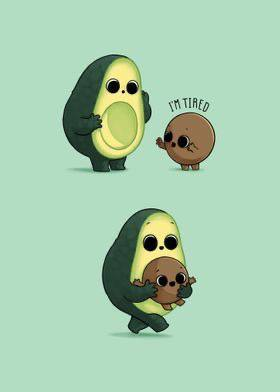

### **2. Visualize the time series. Try to use different plot types. Split your time series into train and test parts**


[Text(0.5, 1.0, 'Scatter plot for avocado revenues from 2015 to 2020 (in $, thousands)'),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '$, thousands')]

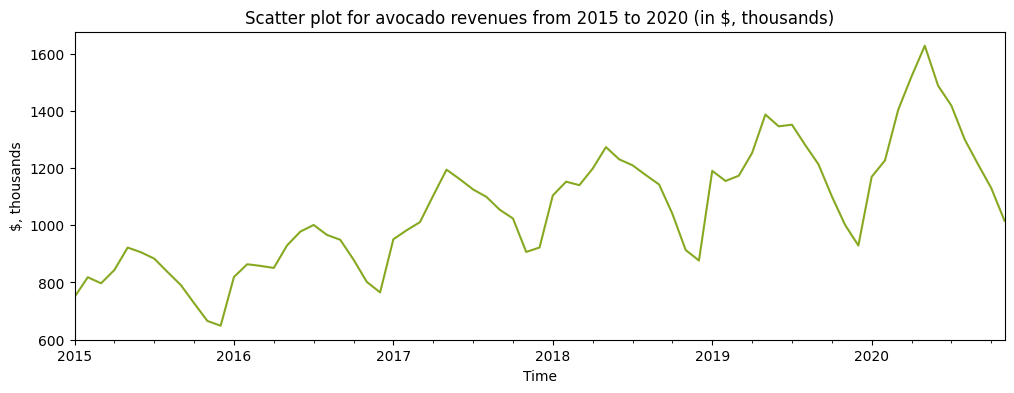

In [ ]:
# Scatter plot
ax = df.plot(figsize = (12,4), legend = None, y='revenue', x='date', color='#87a922')
ax.set(title = 'Scatter plot for avocado revenues from 2015 to 2020 (in $, thousands)', xlabel = 'Time', ylabel = '$, thousands')

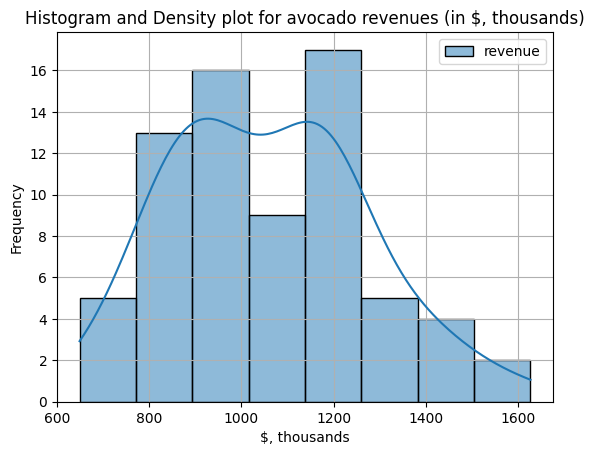

In [ ]:
# Histogram and Density Plot
import seaborn as sns, matplotlib.pyplot as plt
ax = sns.histplot(df, kde = True, color='#87a922')
ax.set(title = 'Histogram and Density plot for avocado revenues (in $, thousands)', xlabel = '$, thousands', ylabel = 'Frequency')
plt.grid(True)
plt.show()

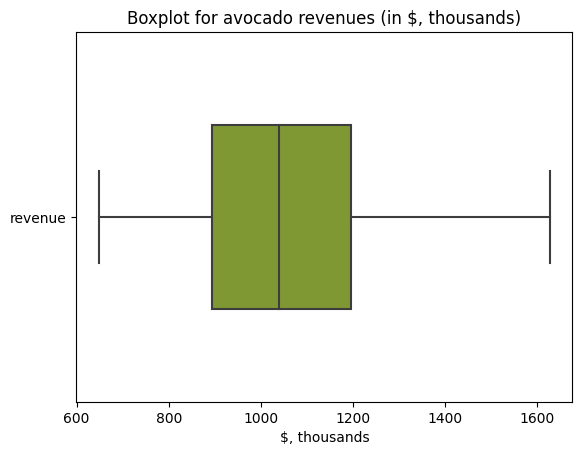

In [ ]:
# Boxplot
ax = sns.boxplot(data = df, width = 0.5, color = '#87a922', orient = 'horizontal')
ax.set(title = 'Boxplot for avocado revenues (in $, thousands)', xlabel = '$, thousands')
plt.show()

In [ ]:
df_for = df
# Ensure data is sorted by date
df_for = df_for.sort_values('date')
df_for.set_index('date', inplace=True)

# Feature Engineering: Create lag features to incorporate historical information
for i in range(1, 4):  # Here we consider 3 lags; you can modify the number of lags based on your data
    df_for[f'lag_{i}'] = df_for['revenue'].shift(i)

# Drop the NaN values created by lag features
df_for = df_for.dropna()

# Split the dataset into a training set and a test set (let's use the last 20% of data for testing)
train_size = int(len(df_for) * 0.8)
train_dfs = df_for.iloc[:train_size]
test_dfs = df_for.iloc[train_size:]

X_train = train_dfs.drop(['revenue'], axis=1)
y_train = train_dfs['revenue']
X_test = test_dfs.drop(['revenue'], axis=1)
y_test = test_dfs['revenue']

Test set trying to get 30% of data instead of 20% and angry train set:

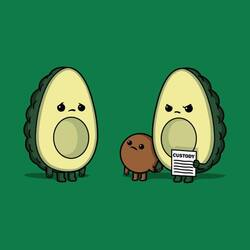

### **3. Decompose the time series into three components (trend, seasonal part, noise) and plot them. Here you may use ETS model or any other decomposition technique.**

In [ ]:
! pip install statsmodels

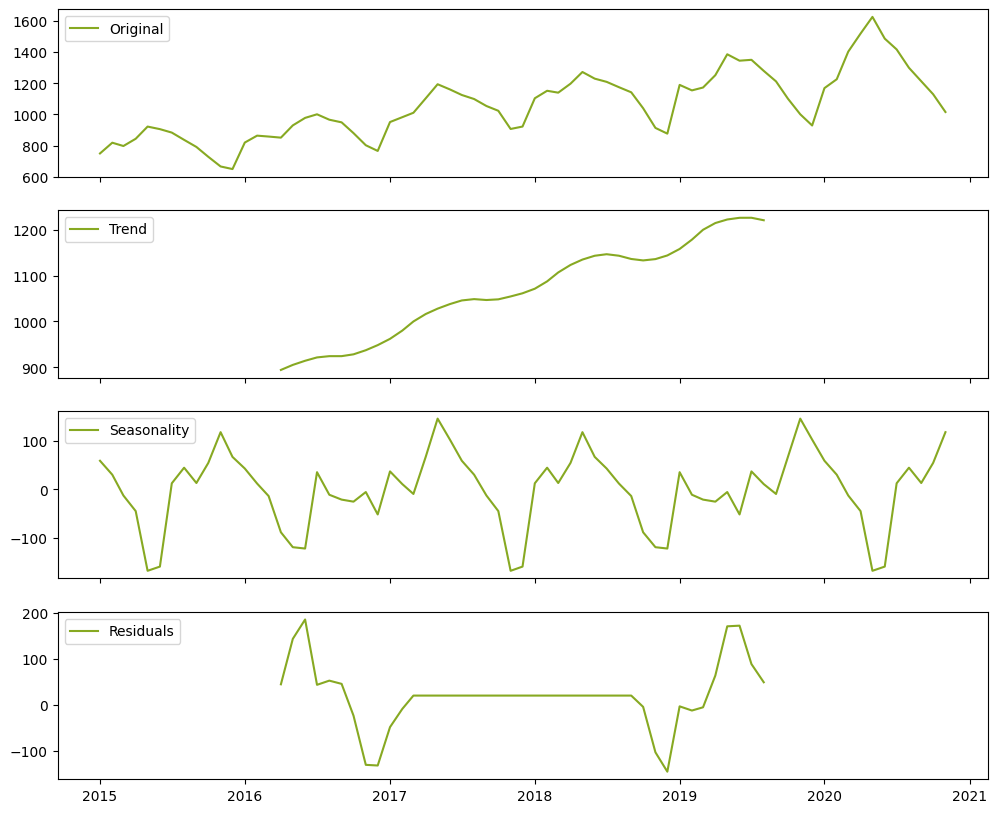

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(df['revenue'], model='additive', period=30)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(12)

axes[0].plot(df['date'], df['revenue'],  label='Original', color = '#87a922')
axes[0].legend(loc='upper left');

axes[1].plot(df['date'], estimated_trend, label='Trend', color = '#87a922')
axes[1].legend(loc='upper left');

axes[2].plot(df['date'], estimated_seasonal, label='Seasonality', color = '#87a922')
axes[2].legend(loc='upper left');

axes[3].plot(df['date'], estimated_residual, label='Residuals', color = '#87a922')
axes[3].legend(loc='upper left');

### **4. Make forecasts using Random Forest or Gradient Boosting. Clearly describe the features you create. You may use any additional predictors**

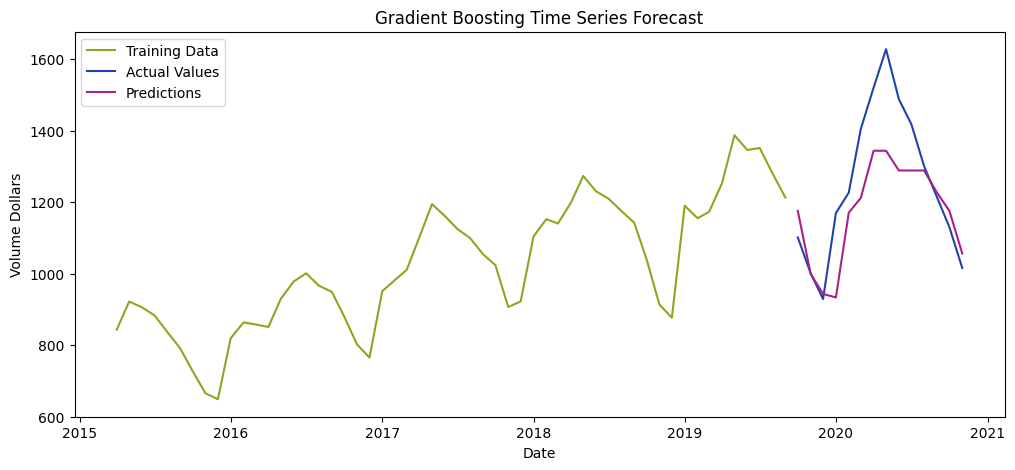

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Create and fit the Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_train, y_train)

# Making predictions
predictions = gb_regressor.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, predictions)
mae_rf = mean_absolute_error(y_test, predictions)

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(train_dfs.index, train_dfs['revenue'], label='Training Data', color = '#87a922')
plt.plot(test_dfs.index, test_dfs['revenue'], label='Actual Values', color = '#2143a9')
plt.plot(test_dfs.index, predictions, label='Predictions', color = '#a92187')
plt.legend()
plt.title('Gradient Boosting revenue forecast')
plt.xlabel('Date')
plt.ylabel('Volume Dollars')

plt.show()

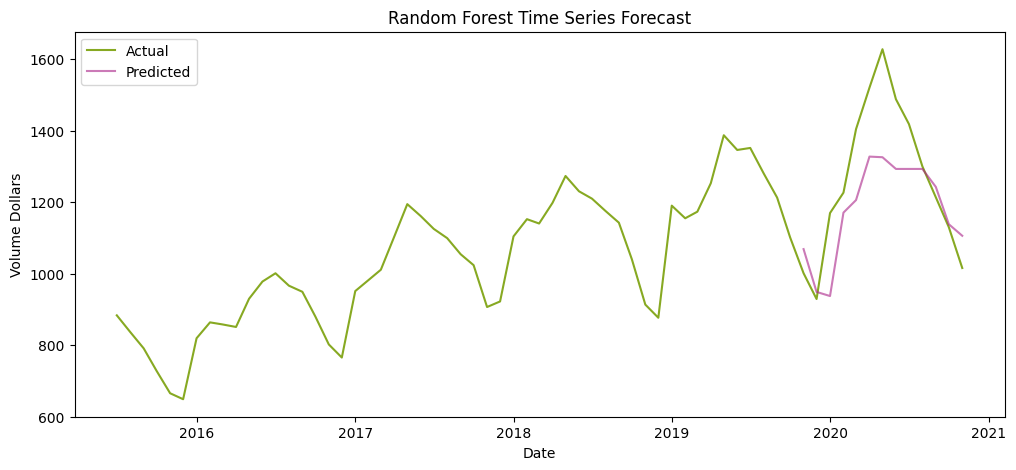

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Creating lag features for historical values to input into the Random Forest
for lag in range(1, 4):  # for simplicity, creating 3 lag features; you can create more or fewer based on your dataset
    df_for[f'lag_{lag}'] = df_for['revenue'].shift(lag)

# Dropping the rows with NaN values that were created by lagging features
df_for = df_for.dropna()

# Feature and target creation
X = df_for.drop('revenue', axis=1)
y = df_for['revenue']

# Train-test split
# For time series data, you don't want to shuffle the data when creating your train/test sets
split_idx = int(0.8 * len(df_for))  # 80-20 train-test split
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Creating and training the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions
y_pred = rf_model.predict(X_test)

# Calculate mean squared error for random forest forecast
mse_gb = mean_squared_error(y_test, y_pred)
mae_gb = mean_absolute_error(y_test, y_pred)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(df_for.index, df_for['revenue'], label='Actual', color = '#87a922')
plt.plot(X_test.index, y_pred, label='Predicted', color='#a92187', alpha=0.6)
plt.title('Random Forest revenue forecast')
plt.xlabel('Date')
plt.ylabel('Volume Dollars')
plt.legend()
plt.show()

After realizing that only one way of forecasting was needed, but you have already done both:

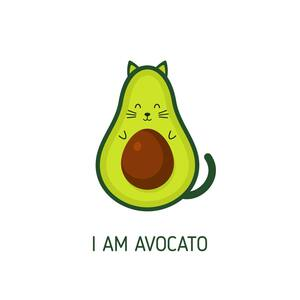

### **5. Make forecasts using appropriate model of ETS class**

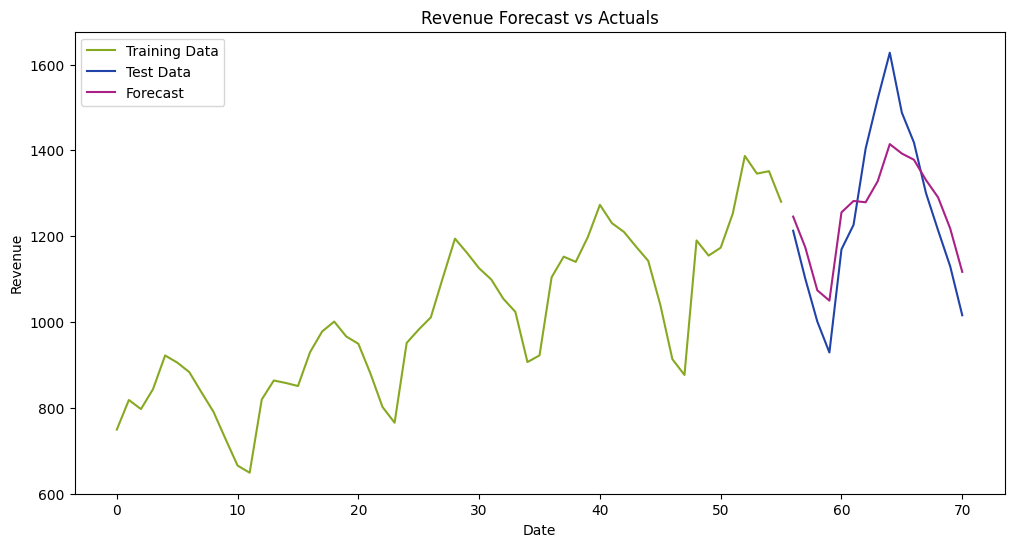

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'df_ets' has 'date' as DateTimeIndex and contains the 'revenue' column
df_ets = df
# Determine the split point for training and test sets (80% for training, 20% for testing)
split_point = int(len(df_ets) * 0.8)

# Split the data into training and test sets
train = df_ets.iloc[:split_point]
test = df_ets.iloc[split_point:]

# Fit an ETS model on the training data
model = ETSModel(train['revenue'], error='add', trend='add', seasonal='add', damped_trend=True, seasonal_periods=12)
fitted_model = model.fit()

# Forecast the same length as the test set
forecast = fitted_model.forecast(steps=len(test))

# Add the forecasted values back to the corresponding datetime index for plotting
forecast_indexed = pd.Series(forecast, index=test.index)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train['revenue'], label='Training Data', color = '#87a922')
plt.plot(test['revenue'], label='Test Data', color='#2143a9')
plt.plot(forecast_indexed, label='Forecast', color='#a92187')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('ETS revenue forecast')

# Show plot
plt.show()

# Calculate accuracy metrics
mse_ets = mean_squared_error(test['revenue'], forecast)
mae_ets = mean_absolute_error(test['revenue'], forecast)

### **6. Make forecasts using any statistical model or machine learning algorithm of your choice.**

In [ ]:
!pip install prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2i_2ve/1o83hu8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca2i_2ve/ry8vhy2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13355', 'data', 'file=/tmp/tmpca2i_2ve/1o83hu8_.json', 'init=/tmp/tmpca2i_2ve/ry8vhy2x.json', 'output', 'file=/tmp/tmpca2i_2ve/prophet_modelt121s7hm/prophet_model-20231218085230.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:52:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:52:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


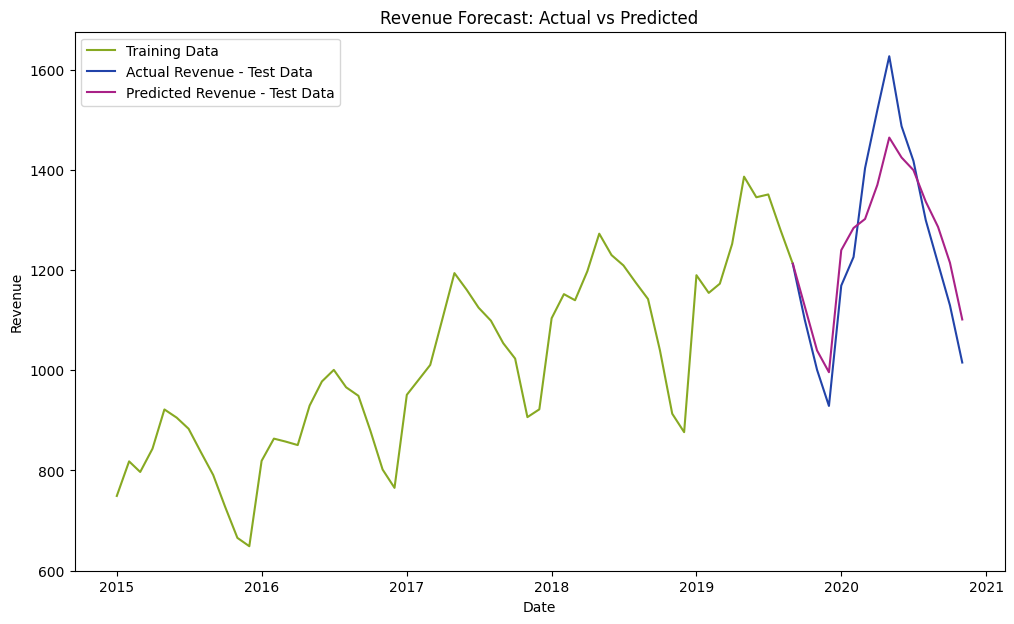

In [ ]:
from prophet import Prophet
import pandas as pd

# Resetting the index of df to make 'date' a column
df_cr_reset = df.reset_index()

# Renaming columns as required by Prophet
df_prophet = df_cr_reset.rename(columns={'date': 'ds', 'revenue': 'y'})

# Instantiate a new Prophet object
model = Prophet()

# Fit the model with your dataframe
model.fit(df_prophet)

# Create a dataframe to hold predictions
future = model.make_future_dataframe(periods=0)  # We use periods=0 since the future dates are already in the dataframe

# Predict
forecast = model.predict(future)

# Prophet returns a dataframe with several columns, but we're mainly interested in 'ds', 'yhat', 'yhat_lower', and 'yhat_upper'
# 'yhat' is the predicted value

# Calculate the index to split the dataset into training and testing (80% train, 20% test)
split_index = int(df_prophet.shape[0] * 0.8)
df_prophet_train = df_prophet.loc[:split_index]
df_prophet_test = df_prophet.loc[split_index:]

# We can now compare the actual vs. predicted values for the test set
y_true = df_prophet_test['y'].values
y_pred = forecast.loc[split_index:, 'yhat'].values


# Visualization
# Plot the forecast alongside the actual data for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(df_prophet_train['ds'], df_prophet_train['y'], label='Training Data', color='#87a922')
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='Actual Revenue - Test Data', color='#2143a9')
plt.plot(df_prophet_test['ds'], y_pred, label='Predicted Revenue - Test Data', color='#a92187')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Prophet revenue forecast')
plt.legend()
plt.show()

# Calculate accuracy metrics
mse_pro = mean_squared_error(y_true, y_pred)
mae_pro = mean_absolute_error(y_true, y_pred)

When trying new way to forecast data and having repeated errors in code:


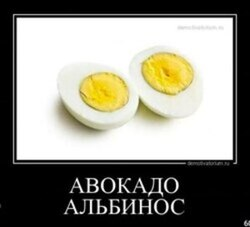

### **7. Compare the three approaches by the forecast quality on the test set. Choose the best approach**

In [ ]:
# Create a DataFrame with the values
metrics_data = {
    'MSE': [mse_gb, mse_rf, mse_ets, mse_pro],
    'MAE': [mae_gb, mae_rf, mae_ets, mae_pro]
}
metrics_df = pd.DataFrame(metrics_data, index=['Gradient Boosting', 'Random Forest', 'ETS', 'Prophet'])

# Function to highlight the minimum in a Series yellow.
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #87a922' if v else '' for v in is_min]

# Apply the highlight function to the DataFrame
highlighted_metrics_df = metrics_df.style.apply(highlight_min)

# Display the DataFrame with highlighted minimum values
highlighted_metrics_df

,MSE,MAE
Gradient Boosting,22515.678349,117.235378
Random Forest,19592.122947,105.427033
ETS,11354.115820,93.582220
Prophet,6657.116484,69.175707


As the best approach is considered to be the one with least MSE and MAE, our final choice is Prophet forecasting model

The project is waiting for your marking <3

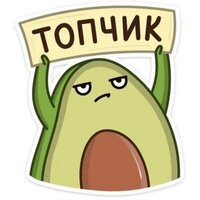